## LSTAM预测时序

### 1.1 为什么使用LSTM处理时序问题
1. LSTM擅长处理"跨很长序列的输入数据",它擅长处理有记忆状态的数据
2. LSTM可以无缝处理"多个输入变量产生多个输出变量的问题",我们要做的只是构造一个3D的输入向量提供给LSTM.而传统的线性回归则只能预测一个输出变量
3. LSTM可以灵活组合使用:  
  1. 可以组合一些seq2seq LSTM模型来预测时序, 比如
    1. 多对一 : 用所有之前时间步的输入数据预测当前时间戳下的输出数据
    2. 多对多 : 用所有之前时间步的输入数据预测未来多个时间步的输出
  2. 可以自定义预测当前时间步的输出所需的look-back窗口大小
  
### 1.2 让我们看一个LSTM处理正弦波的问题

In [1]:
import pandas as pd
import numpy as np
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


#### 1. 导入数据, 画折线图

In [2]:
df = pd.read_csv("data/sine-wave.csv",header=None)
print df.shape
df.head()

(5001, 1)


,0
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


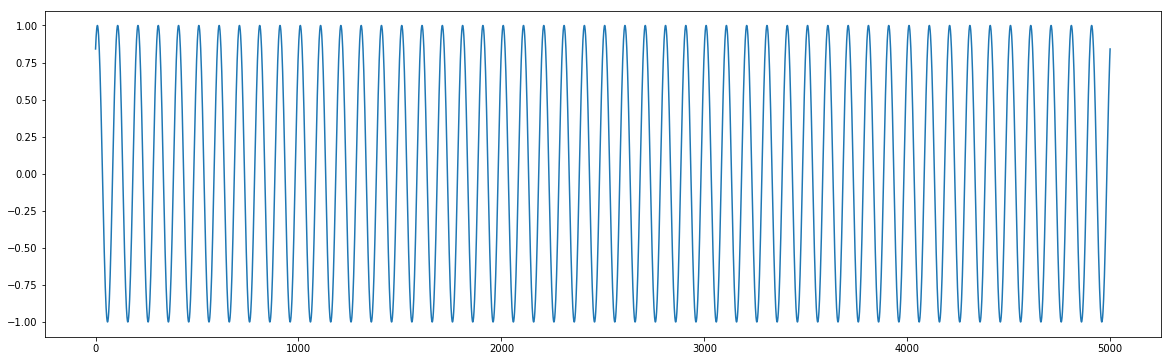

In [3]:
fig = plt.figure(figsize=(20,6))
plt.plot(df.values)
plt.show()

#### 2. 正则化数据

In [4]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaledData = scaler.fit_transform(df.values)
data = pd.DataFrame(scaledData) # ndarray to dataframe

#### 3. 构造包含前50个时间步的数据

In [5]:
lookback_window = 50
data_copy = data.copy() # 用于后续shift操作
# dataframe.shift(number):number>0下移n行,number<0上移n行
for i in range(0,lookback_window):
    data = pd.concat([data,data_copy.shift(-(i+1))],axis=1)
print data.shape
data.tail() # 看到尾部数据有多个NaN,因为dataframe.shift(-1),为向上提升1行

(5001, 51)


,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0.680677,0.725334,0.767129,0.805896,0.841483,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,0.725334,0.767129,0.805896,0.841483,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4998,0.767129,0.805896,0.841483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4999,0.805896,0.841483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000,0.841483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 删除带有nan的数据, axis=0:index,axis=1:column
data.dropna(axis=0,inplace=True) 
data.shape

(4951, 51)

In [7]:
# 80%训练数据,20%测试数据
ntrain = int(round(0.8*data.shape[0]))
print ntrain
data_train = data.iloc[:ntrain,:] #[0,ntrain-1]
data_test = data.iloc[ntrain:,:]
print data_train.shape[0]+data_test.shape[0]

# 混洗训练数据
from sklearn.utils import shuffle
data_train = shuffle(data_train)

3961
4951


In [8]:
# 把dataframe最后一列作为输出
train_x = data_train.iloc[:,:-1]
train_y = data_train.iloc[:,-1]
test_x = data_test.iloc[:,:-1]
test_y = data_test.iloc[:,-1]

In [9]:
# 将dataframe转换为ndarray,供lstm使用
train_x = train_x.values
train_y = train_y.values
test_x = test_x.values
test_y = test_y.values

print train_x.shape
print train_y.shape
print test_x.shape
print test_y.shape

(3961, 50)
(3961,)
(990, 50)
(990,)


#### 4. 构造3D数据,作为lstm的输入 
3D数据结构:(样本个数num_samples, 时间步个数num_time_steps, 特征个数num_feature)  
此处我们有num of time steps = 50 and num_features = 1 

In [10]:
# 将x转变为3d数据
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],1)
test_x = test_x.reshape(test_x.shape[0],test_x.shape[1],1) 
train_y = train_y.reshape(train_y.shape[0],1)
test_y = test_y.reshape(test_y.shape[0],1)

print train_x.shape
print test_x.shape
print train_y.shape
print test_y.shape

(3961, 50, 1)
(990, 50, 1)
(3961, 1)
(990, 1)


#### 5. 构造lstm模型
我们使用两层LSTM模型, 第一层的LSTM结果会输送给第二层LSTM

In [14]:
model = Sequential()
# 第一层
model.add(LSTM(input_shape=(50,1),output_dim=1,return_sequences=True))
# 第二层
model.add(LSTM(256))
# 第三层: 全连接层
model.add(Dense(1))
# 输出层: 线性回归输出
model.add(Activation("linear"))

model.compile(loss='mse',optimizer='adam') # 后面评价也是用均方误差
model.summary()

/Users/lj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=True, input_shape=(50, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 1)             12        
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 264,461
Trainable params: 264,461
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(train_x,train_y,batch_size=32,nb_epoch=3,validation_split=0.1)

Train on 3564 samples, validate on 397 samples
Epoch 1/3
3564/3564 [==============================] - 11s 3ms/step - loss: 0.0630 - val_loss: 1.6006e-04
Epoch 2/3
3564/3564 [==============================] - 10s 3ms/step - loss: 1.3871e-04 - val_loss: 2.1827e-04
Epoch 3/3
3564/3564 [==============================] - 10s 3ms/step - loss: 1.6147e-04 - val_loss: 6.5405e-04


#### 6. 用训练好的模型预测数据, 画出真实数据和预测数据的交叉的折线图
两种预测方式:   
1. 预测所有的测试序列, 输出下一个时间步的数据
2. 预测未来多个时间步的数据: 每次预测一个时间步的数据, 在使用这个预测到的数据作为下次预测的输入数据  
  这种方式我们看到, 离输入数据的时间步越远, 预测数据与真实数据的差异越大(网络训练的好则差异不大)

In [16]:
# 第一种预测输出
# 预测输出, 并还原输出形式为之前的形式
preds = model.predict(test_x)
print preds.shape
print type(preds)
preds = scaler.inverse_transform(preds) 
test_y = test_y.reshape(test_y.shape[0],1)
print test_y.shape
print type(test_y)
actuals = scaler.inverse_transform(test_y)

mean_squared_error(actuals,preds)

(990, 1)
<type 'numpy.ndarray'>
(990, 1)
<type 'numpy.ndarray'>


0.00063646916924439982

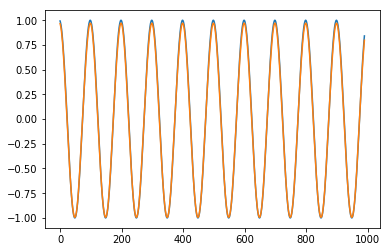

In [17]:
plt.plot(actuals)
plt.plot(preds)
plt.show()

(990, 50, 1)
(1, 50, 1)
(990, 1)
(900, 1)


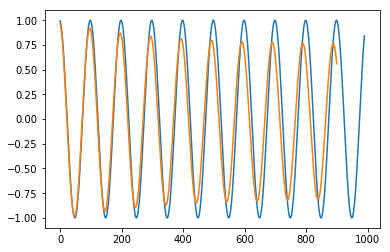

In [18]:
# 第二种预测
preds_num = 900
preds = []
# 1. 从第一个时间步开始, 逐步预测
print test_x.shape  # test_x:3d数据, (990, 50, 1)
current_step = np.array([test_x[0,:,:]])
print current_step.shape  # 测试集的第一个输入(1,50,1),里面没有空值
for i in range(0,preds_num):
    preds_one_step = model.predict(current_step)
    preds.append(preds_one_step[0][0])
    # 整理preds_one_step为3d数据
    preds_one_step = preds_one_step.reshape(1,1,1)
    # current_step[:,1:,:].shape = (1, 49, 1), 每次都抛弃第一个数表示时间步前进一个
    # preds_one_step.shape = (1,1,1)
    # concatenate之后形成新的(1,50,1)
    current_step = np.concatenate((current_step[:,1:,:],preds_one_step),axis=1)

preds = scaler.inverse_transform(np.array(preds).reshape(preds_num,1))
print actuals.shape
print preds.shape
plt.plot(actuals)
plt.plot(preds)
plt.show()